In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
dowjones = pd.read_csv('DowJones Daily Returns.csv')
dowjones.head(10)

,PERMNO,date,SICCD,TICKER,COMNAM,HSICIG,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,NUMTRD,RETX,sprtrn,enterdate,positive,negative,total,market_cap
0,10104,2023-01-03,7372.0,ORCL,ORACLE CORP,NaN,82.260,83.8400,83.72,8997534.0,0.024223,2696253.0,NaN,0.024223,-0.004001,NaN,0.0,0.0,0.0,2.257303e+08
1,10104,2023-01-04,7372.0,ORCL,ORACLE CORP,NaN,83.640,85.1700,84.48,7836238.0,0.009078,2696253.0,NaN,0.009078,0.007539,NaN,0.0,0.0,0.0,2.277795e+08
2,10104,2023-01-05,7372.0,ORCL,ORACLE CORP,NaN,83.220,85.4000,84.31,7643784.0,-0.002012,2696253.0,NaN,-0.002012,-0.011646,NaN,0.0,0.0,0.0,2.273211e+08
3,10104,2023-01-06,7372.0,ORCL,ORACLE CORP,NaN,83.820,86.3400,85.66,8641597.0,0.016012,2696253.0,NaN,0.016012,0.022841,NaN,0.0,0.0,0.0,2.309610e+08
4,10104,2023-01-09,7372.0,ORCL,ORACLE CORP,NaN,86.160,87.5900,86.42,7519836.0,0.012608,2696253.0,NaN,0.008872,-0.000768,NaN,0.0,0.0,0.0,2.330102e+08
5,10104,2023-01-10,7372.0,ORCL,ORACLE CORP,NaN,85.570,86.6100,86.50,5703270.0,0.000926,2696253.0,NaN,0.000926,0.006978,NaN,0.0,0.0,0.0,2.332259e+08
6,10104,2023-01-11,7372.0,ORCL,ORACLE CORP,NaN,87.090,88.6600,88.60,8359667.0,0.024277,2696253.0,NaN,0.024277,0.012849,NaN,0.0,0.0,0.0,2.388880e+08
7,10104,2023-01-12,7372.0,ORCL,ORACLE CORP,NaN,88.170,89.1950,88.78,6071099.0,0.002032,2696253.0,NaN,0.002032,0.003416,2023-01-12,1.0,0.0,1.0,2.393733e+08
8,10104,2023-01-13,7372.0,ORCL,ORACLE CORP,NaN,87.660,89.4662,89.20,5090938.0,0.004731,2696253.0,NaN,0.004731,0.003997,NaN,0.0,0.0,0.0,2.405058e+08
9,10104,2023-01-17,7372.0,ORCL,ORACLE CORP,NaN,88.425,89.4400,88.60,6550412.0,-0.006726,2696253.0,NaN,-0.006726,-0.002030,2023-01-17,0.0,0.0,1.0,2.388880e+08


             SICCD    market_cap        SHROUT           VOL            PRC  \
count   360.000000  3.600000e+02  3.600000e+02  3.600000e+02     360.000000   
mean   5334.488889  5.522753e+08  3.383037e+06  2.038684e+07    8724.607341   
std    2249.318329  5.819878e+08  3.294837e+06  2.851538e+07   45864.022072   
min    2086.000000  1.593079e+08  4.126850e+05  1.397228e+06      26.353636   
25%    2911.000000  2.632982e+08  1.005376e+06  4.039995e+06     116.110568   
50%    5330.000000  3.592332e+08  2.470000e+06  7.769490e+06     164.753895   
75%    7372.000000  4.666795e+08  4.094882e+06  2.580584e+07     350.348753   
max    9999.000000  3.022032e+09  1.583174e+07  1.947476e+08  275845.278937   

               ASKHI       BIDLO       total    negative    positive  \
count     360.000000  360.000000  360.000000  360.000000  360.000000   
mean    17732.780577  224.736483   16.700000    0.177778    2.530556   
std     94443.364729  166.996411   13.494619    0.479735    2.829246   


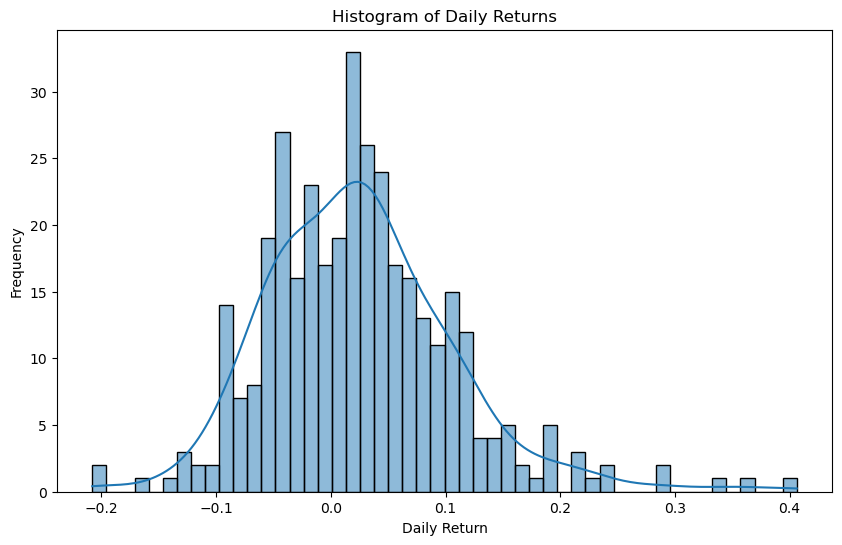

In [3]:
# Change date format
dowjones['date'] = pd.to_datetime(dowjones['date'], format='%Y-%m-%d')

# Remove the columns HSICIG and enterdate
dowjones.drop(columns=['HSICIG', 'enterdate', 'NUMTRD'], inplace=True)

# Reset index
dowjones.reset_index(drop=True, inplace=True)


# Group by month and ticker and perform aggregations
agg_columns = {
    'SICCD': 'first',
    'COMNAM': 'first',
    'market_cap': 'mean',
    'SHROUT': 'mean',
    'VOL': 'mean',
    'PRC': 'mean',
    'ASKHI': 'max',
    'BIDLO': 'min',
    'total': 'sum',
    'negative': 'sum',
    'positive': 'sum',
    'sprtrn': lambda x: (1 + x).prod() - 1,
    'RET': lambda x: (1 + x).prod() - 1
}

# Group by 'TICKER' and resample the data to monthly frequency
dowjones = dowjones.groupby('TICKER').resample('M', on='date').agg(agg_columns).reset_index()

# Adding lagged columns
dowjones['next_month_return'] = dowjones.groupby('TICKER')['RET'].shift(-1)
dowjones['last_month_return'] = dowjones.groupby('TICKER')['RET'].shift(1)
dowjones['last_month_volume'] = dowjones.groupby('TICKER')['VOL'].shift(1)

# Add columns for moving averages
dowjones['1_month_ma'] = dowjones.groupby('TICKER')['PRC'].rolling(window=1).mean().reset_index(drop=True)
dowjones['2_month_ma'] = dowjones.groupby('TICKER')['PRC'].rolling(window=2).mean().reset_index(drop=True)
dowjones['3_month_ma'] = dowjones.groupby('TICKER')['PRC'].rolling(window=3).mean().reset_index(drop=True)

# Create "proper?" column
dowjones['proper?'] = (dowjones['1_month_ma'] > dowjones['2_month_ma']) & (dowjones['2_month_ma'] > dowjones['3_month_ma']).astype(int)

# Create price minus 
dowjones['Ask_minus_Bid'] = dowjones['ASKHI'] - dowjones['BIDLO']

# Create comp_size column
dowjones['comp_size'] = pd.qcut(dowjones['market_cap'], q=10, labels=False)

# Display summary statistics
print(dowjones.describe())

# Plot histogram of returns
plt.figure(figsize=(10, 6))
sns.histplot(data=dowjones, x='RET', bins=50, kde=True)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


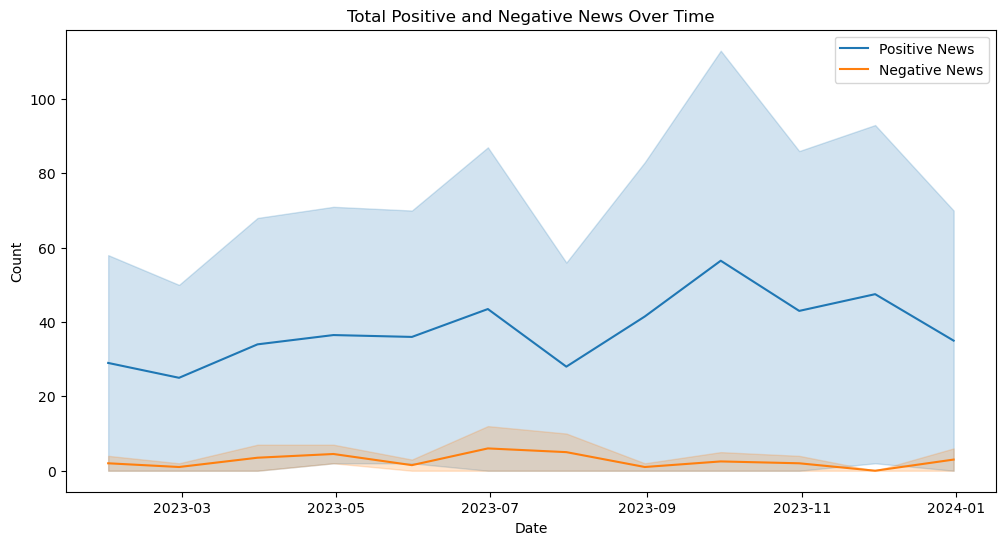

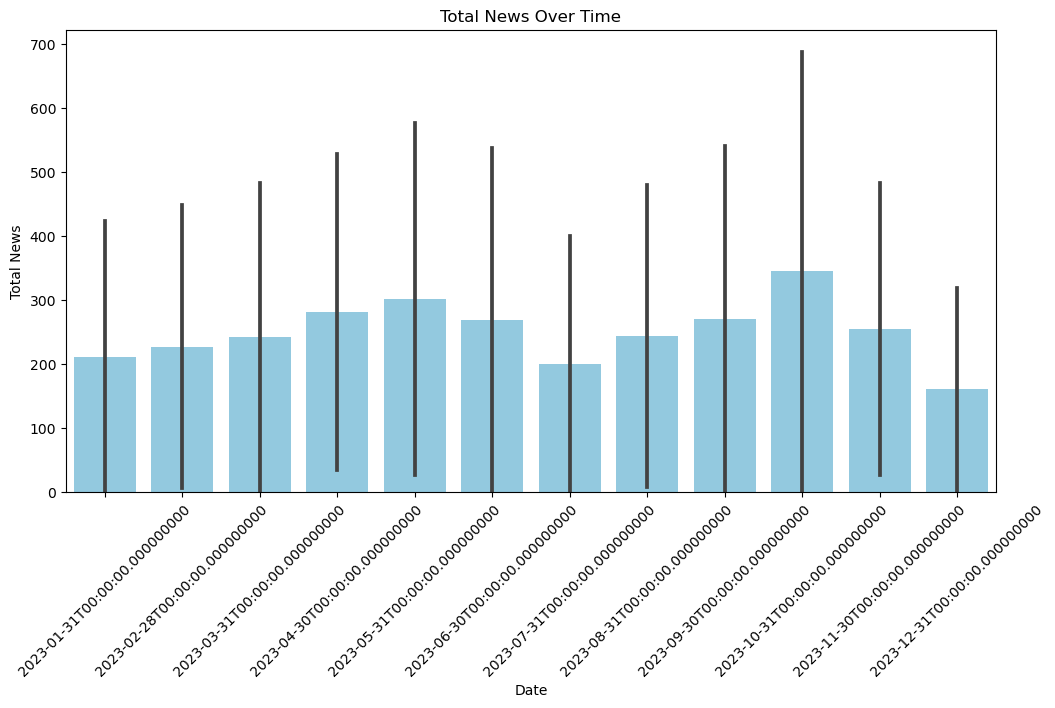

In [4]:
# Daily aggregation
daily_summary = dowjones.groupby(['date', 'sprtrn']).agg(
    sum_positive=('positive', 'sum'),
    sum_negative=('negative', 'sum'),
    sum_total=('total', 'sum')
).reset_index()

# Plot line chart of total positive and negative news over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_summary, x='date', y='sum_positive', label='Positive News')
sns.lineplot(data=daily_summary, x='date', y='sum_negative', label='Negative News')
plt.title('Total Positive and Negative News Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot bar chart of total news over time
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_summary, x='date', y='sum_total', color='skyblue')
plt.title('Total News Over Time')
plt.xlabel('Date')
plt.ylabel('Total News')
plt.xticks(rotation=45)
plt.show()

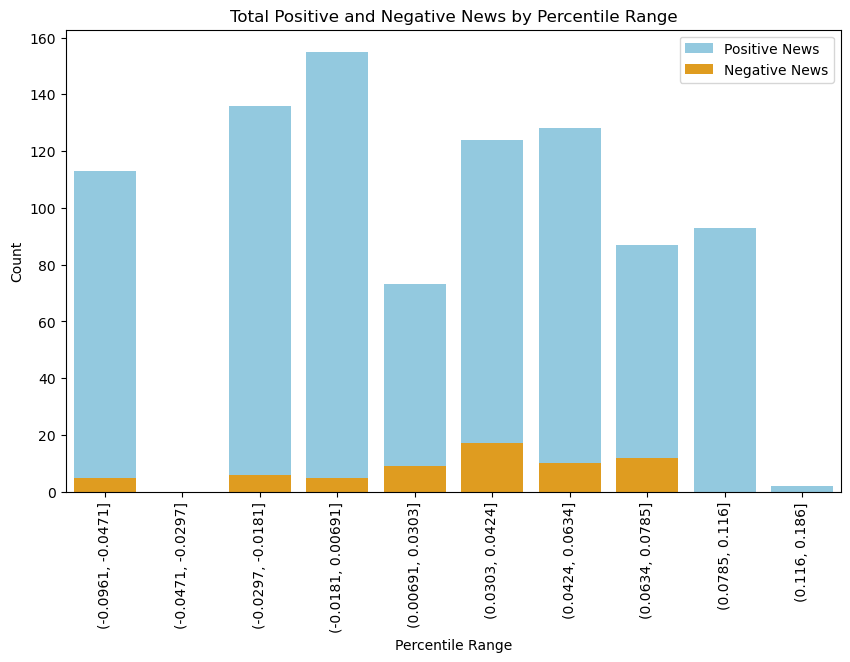

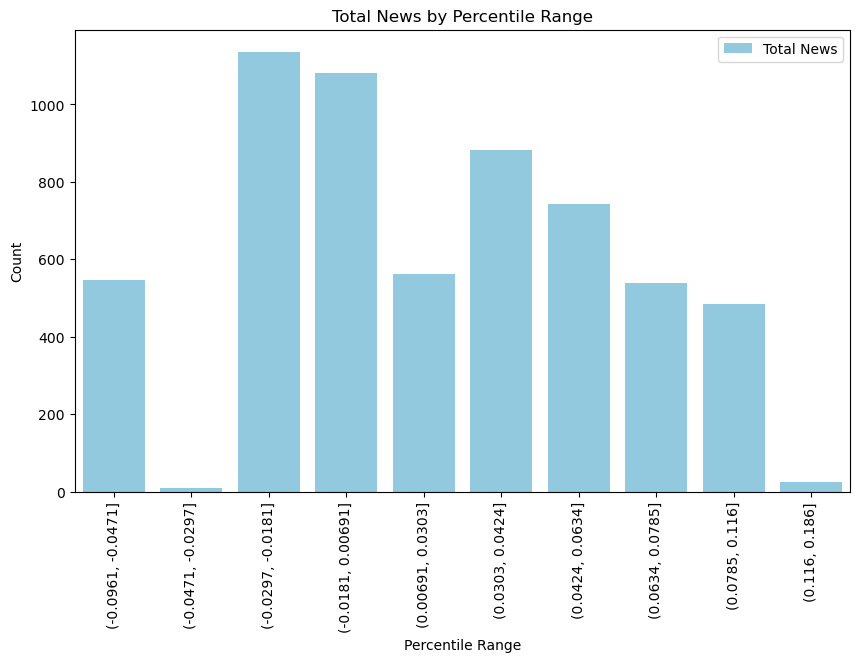

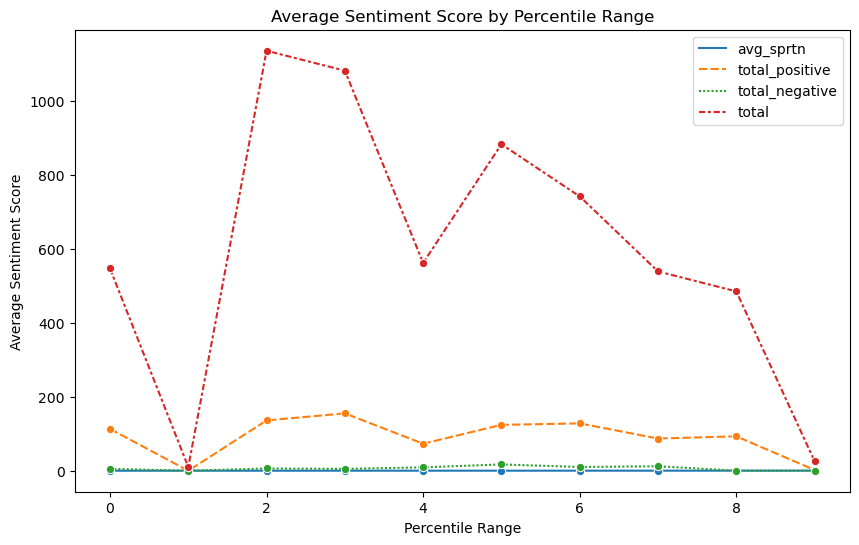

In [5]:
# Percentile summary
ranked_sprtrn = daily_summary.copy()
ranked_sprtrn['sprtrn_percentile'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10, labels=False)
ranked_sprtrn['percentile_range'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10)

percentile_summary = ranked_sprtrn.groupby('percentile_range').agg(
    avg_sprtn=('sprtrn', 'mean'),
    total_positive=('sum_positive', 'sum'),
    total_negative=('sum_negative', 'sum'),
    total=('sum_total', 'sum')
).reset_index()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=percentile_summary, x='percentile_range', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total', color='skyblue', label='Total News')
plt.title('Total News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot line chart of average sentiment score by percentile range
plt.figure(figsize=(10, 6))
sns.lineplot(data=percentile_summary.drop(columns='percentile_range'), marker='o', color='green')
plt.title('Average Sentiment Score by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Average Sentiment Score')
plt.show()


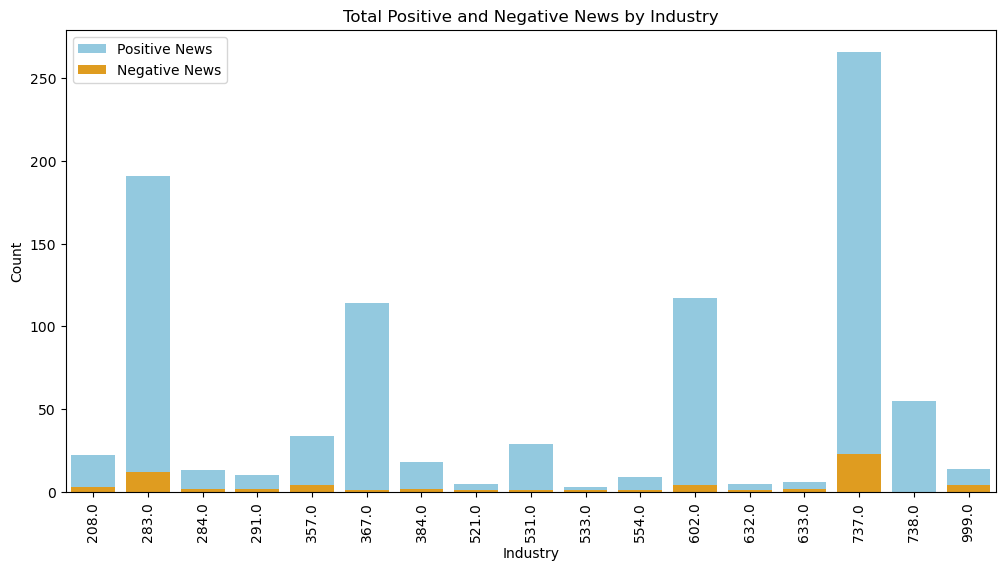

In [6]:
# Industry summary
industry_summary = dowjones.groupby(dowjones['SICCD'] // 10).agg(
    num_firms=('TICKER', 'nunique'),
    cum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

industry_summary['positive_perc'] = industry_summary['total_positive'] / industry_summary['total']
industry_summary['negative_perc'] = industry_summary['total_negative'] / industry_summary['total']

# Plot bar chart of total positive and negative news by industry
plt.figure(figsize=(12, 6))
sns.barplot(data=industry_summary, x='SICCD', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=industry_summary, x='SICCD', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Industry')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()


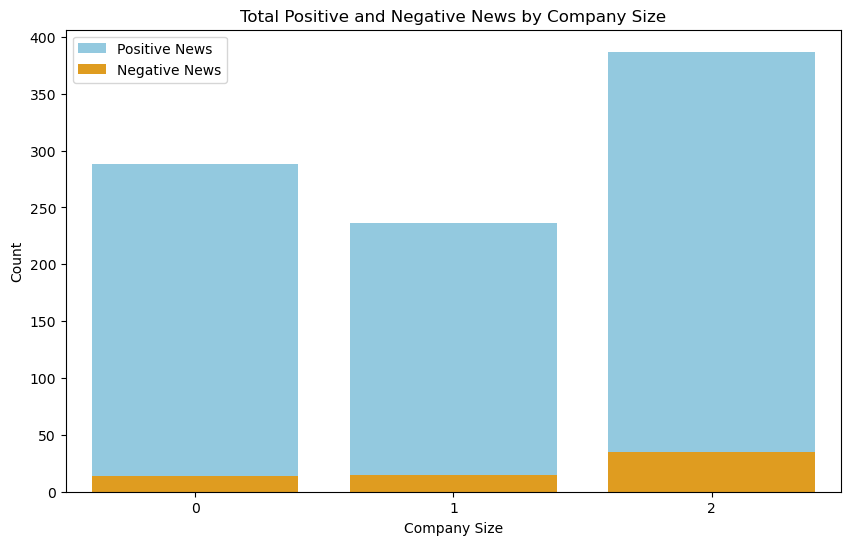

In [7]:
# Company size summary
stock_size = dowjones.copy()
stock_size['comp_size'] = pd.qcut(stock_size['market_cap'], q=3, labels=False)
company_size_summary = stock_size.groupby('comp_size').agg(
    sum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

company_size_summary['positive_perc'] = company_size_summary['total_positive'] / company_size_summary['total']
company_size_summary['negative_perc'] = company_size_summary['total_negative'] / company_size_summary['total']

# Plot bar chart of total positive and negative news by company size
plt.figure(figsize=(10, 6))
sns.barplot(data=company_size_summary, x='comp_size', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=company_size_summary, x='comp_size', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.legend()
plt.show()


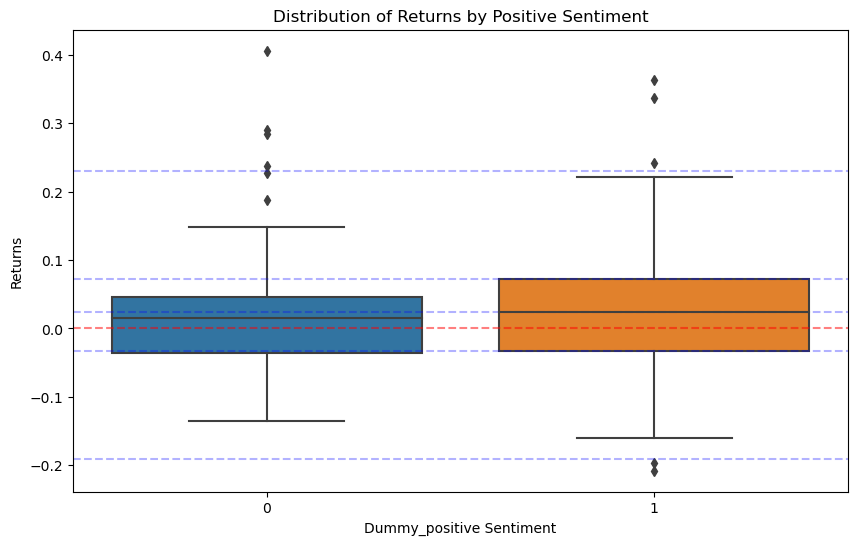

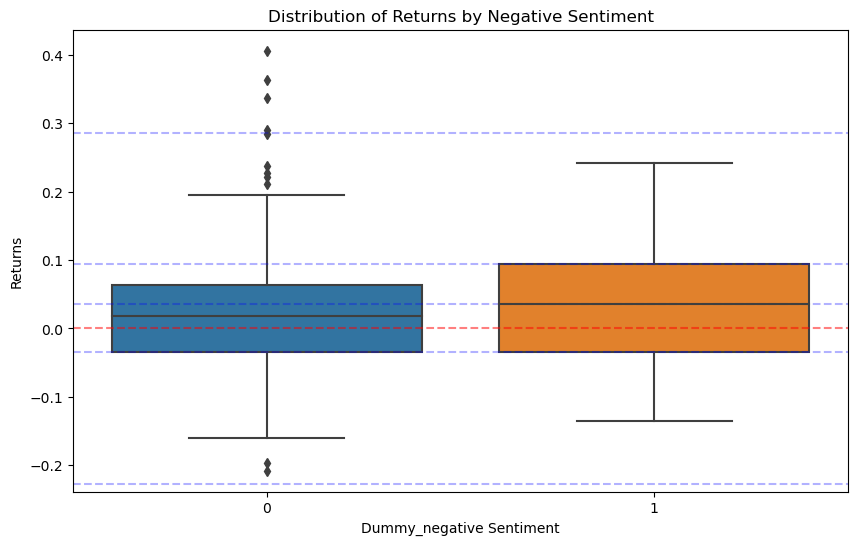

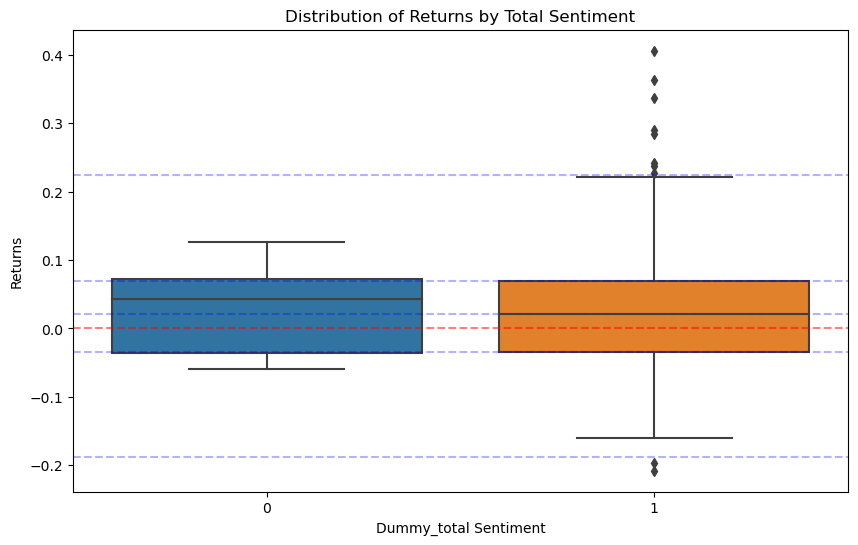

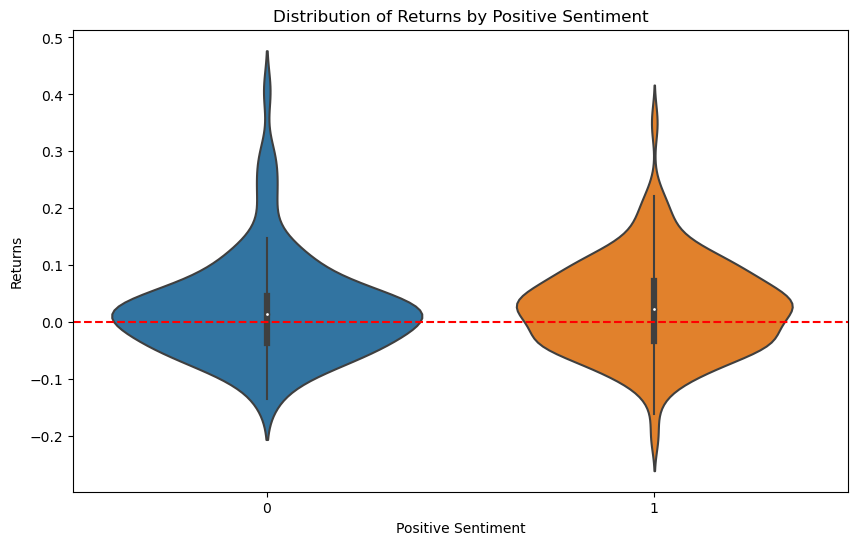

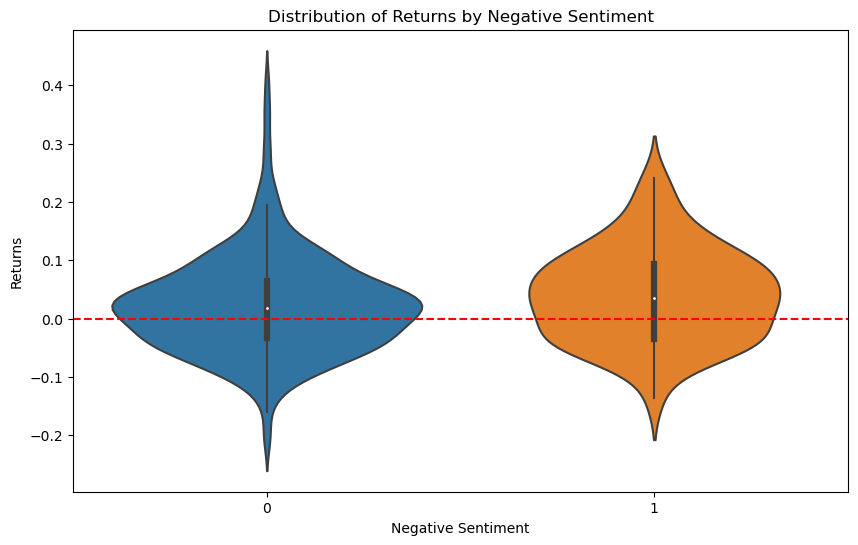

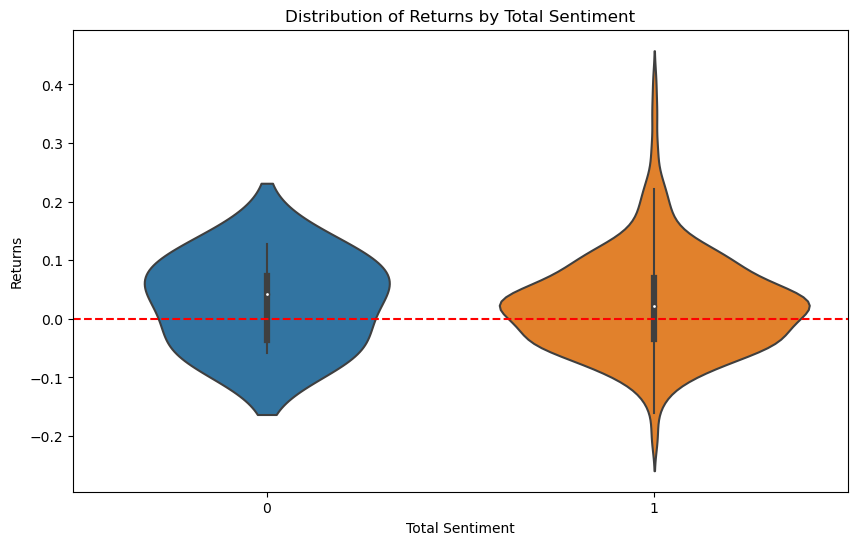

In [8]:
# Create dummy_negative column
dowjones['dummy_negative'] = (dowjones['negative'] >= 1).astype(int)

# Create dummy_positive column
dowjones['dummy_positive'] = (dowjones['positive'] >= 1).astype(int)

# Create dummy_total column
dowjones['dummy_total'] = (dowjones['total'] >= 1).astype(int)


# Function to plot with additional lines
def plot_with_lines(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    # Add blue dashed lines for critical points of value >= 1 category
    for i, box in enumerate(data.groupby(x_col)[y_col]):
        if box[0] == 1:
            quartiles = box[1].quantile([0.25, 0.5, 0.75])
            plt.axhline(y=quartiles[0.25], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.5], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.75], color='blue', linestyle='--', alpha=0.3)              
            iqr = quartiles[0.75] - quartiles[0.25]
            upper_limit = 1.5 * iqr + quartiles[0.75]
            lower_limit = quartiles[0.25] - 1.5 * iqr
            # Add additional blue dashed lines
            plt.axhline(y=upper_limit, color='blue', linestyle='--', alpha=0.3)  # Upper limit
            plt.axhline(y=lower_limit, color='blue', linestyle='--', alpha=0.3)  # Lower limit
    plt.title(title)
    plt.xlabel(x_col.capitalize() + ' Sentiment')
    plt.ylabel('Returns')
    plt.show()


# Box plot for dummy_positive
plot_with_lines(dowjones, 'dummy_positive', 'RET', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(dowjones, 'dummy_negative', 'RET', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(dowjones, 'dummy_total', 'RET', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='RET', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='RET', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='RET', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()


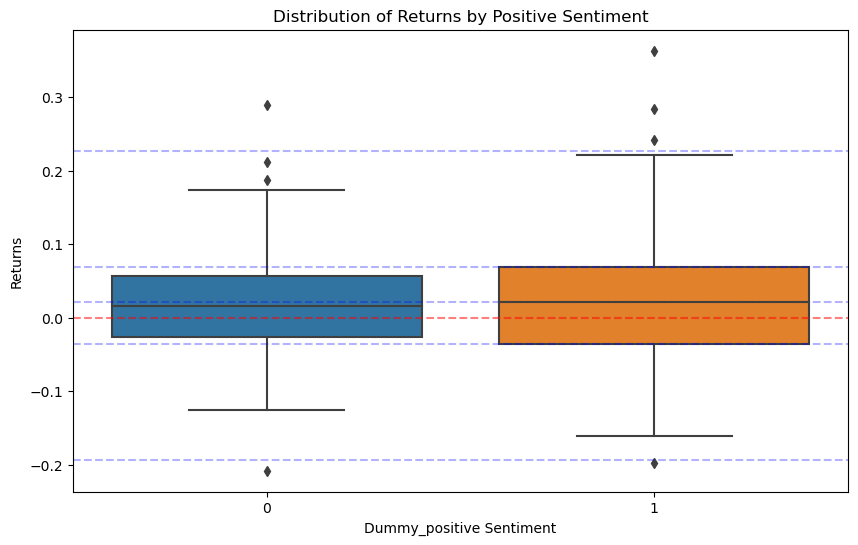

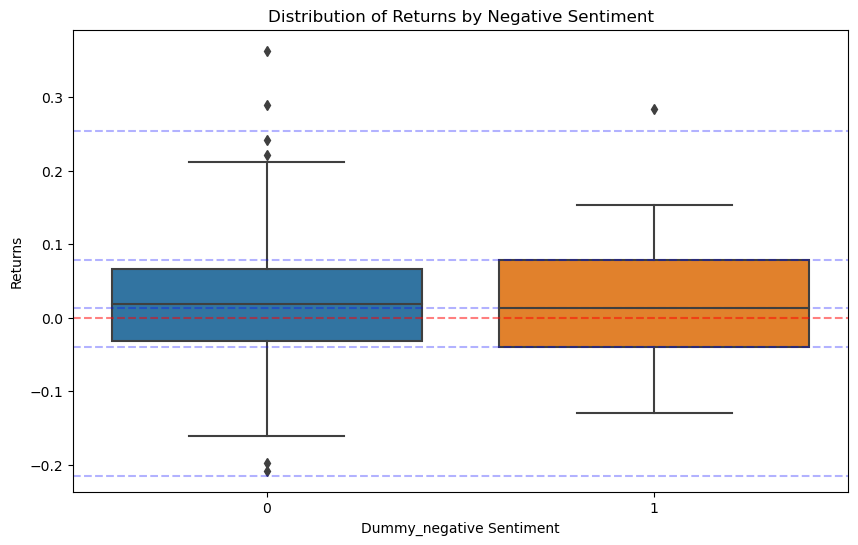

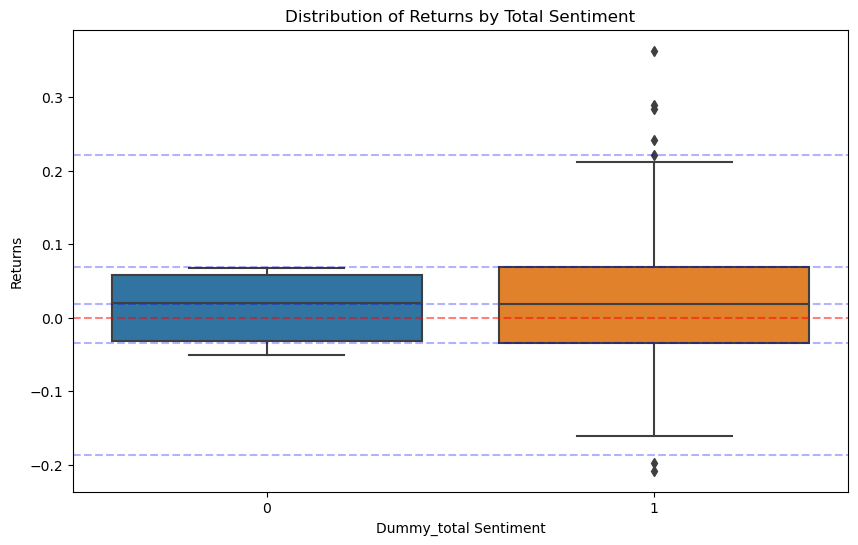

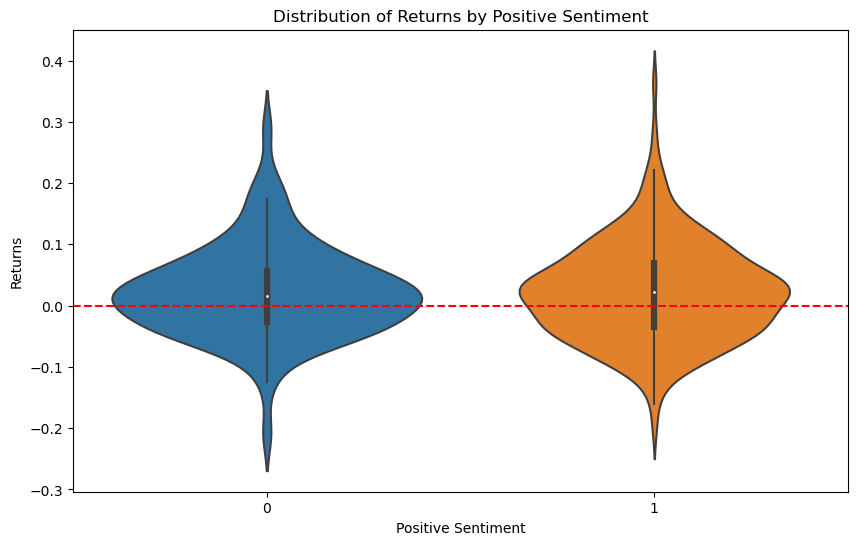

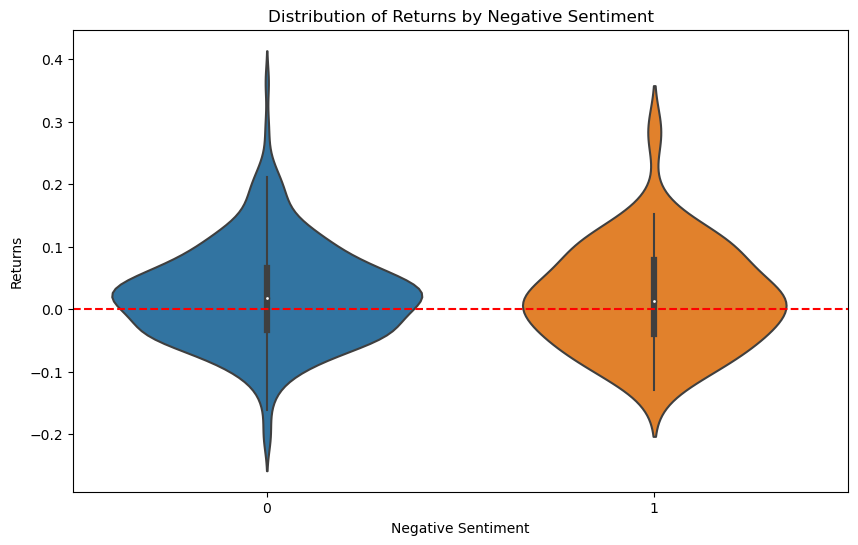

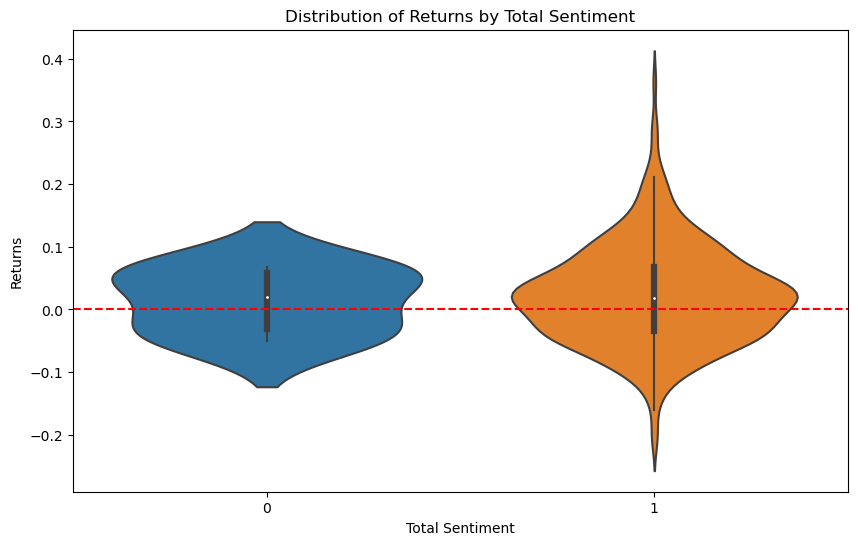

In [9]:
# Box plot for dummy_positive
plot_with_lines(dowjones, 'dummy_positive', 'next_month_return', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(dowjones, 'dummy_negative', 'next_month_return', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(dowjones, 'dummy_total', 'next_month_return', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='next_month_return', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='next_month_return', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='next_month_return', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()

In [10]:
from scipy.stats import ttest_ind, mannwhitneyu

# Define a function to remove outliers using Z-score
def remove_outliers(df, column, threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    df_filtered = df[(z_scores.abs() < threshold)]
    return df_filtered

# Remove outliers from the dowjones DataFrame
dowjones = remove_outliers(dowjones, 'Ask_minus_Bid')
dowjones = remove_outliers(dowjones, 'VOL')
dowjones.to_csv('monthly_dowjones_regression.csv', index=False)

# Calculate mean and standard deviation (volatility) for each combination of dummy variables
mean_negative = dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'].mean()
std_negative = dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'].std()

mean_positive = dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'].mean()
std_positive = dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'].std()

mean_total = dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'].mean()
std_total = dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'].std()

# Calculate mean and standard deviation (volatility) when the dummy variables are equal to zero
mean_negative_zero = dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'].mean()
std_negative_zero = dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'].std()

mean_positive_zero = dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'].mean()
std_positive_zero = dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'].std()

mean_total_zero = dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'].mean()
std_total_zero = dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'].std()

# t-test for mean difference
t_statistic_mean_negative, p_value_mean_negative = ttest_ind(dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                             dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'])

t_statistic_mean_positive, p_value_mean_positive = ttest_ind(dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                             dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'])

t_statistic_mean_total, p_value_mean_total = ttest_ind(dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'],
                                                       dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'])

# Mann-Whitney U test for difference in volatility
u_statistic_vol_negative, p_value_vol_negative = mannwhitneyu(dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                              dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'])

u_statistic_vol_positive, p_value_vol_positive = mannwhitneyu(dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                              dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'])

u_statistic_vol_total, p_value_vol_total = mannwhitneyu(dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'],
                                                        dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'])

# Create a DataFrame to display the results
data = {
    'Dummy': ['Negative', 'Positive', 'Total'],
    'Mean_with_Dummy': [mean_negative, mean_positive, mean_total],
    'Mean_without_Dummy': [mean_negative_zero, mean_positive_zero, mean_total_zero],
    'Volatility_with_Dummy': [std_negative, std_positive, std_total],
    'Volatility_without_Dummy': [std_negative_zero, std_positive_zero, std_total_zero],
    'Mean_Difference': [mean_negative - mean_negative_zero,
                        mean_positive - mean_positive_zero,
                        mean_total - mean_total_zero],
    'Volatility_Difference': [std_negative - std_negative_zero,
                              std_positive - std_positive_zero,
                              std_total - std_total_zero],
    'Mean_P_value': [p_value_mean_negative, p_value_mean_positive, p_value_mean_total],
    'Volatility_P_value': [p_value_vol_negative, p_value_vol_positive, p_value_vol_total]
}
df_results = pd.DataFrame(data)

# Display the results
print(df_results)

      Dummy  Mean_with_Dummy  Mean_without_Dummy  Volatility_with_Dummy  \
0  Negative        26.636527           27.282659              38.287738   
1  Positive        25.005830           33.949172              28.412295   
2     Total        27.140038           35.270005              32.889660   

   Volatility_without_Dummy  Mean_Difference  Volatility_Difference  \
0                 31.841667        -0.646132               6.446072   
1                 43.199469        -8.943343             -14.787174   
2                  2.955713        -8.129967              29.933947   

   Mean_P_value  Volatility_P_value  
0      0.898807            0.758760  
1      0.031594            0.031796  
2      0.727268            0.218610  


In [11]:
# Specify the columns for which to calculate z-scores
columns_to_standardize = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'sprtrn', 'market_cap', 'last_month_return', '1_month_ma', '2_month_ma', 
                          '3_month_ma', 'Ask_minus_Bid', 'last_month_volume']

# Group by ticker and standardize each group for specified columns
dowjones_grouped = dowjones.groupby('TICKER')[columns_to_standardize]

# Define a function to standardize values within each group
def standardize_group(group):
    group_std = (group - group.mean()) / group.std()
    return group_std

# Apply the standardization function to each group
dowjones_standardized = dowjones_grouped.transform(standardize_group)

# Replace original values with standardized values in the original DataFrame
dowjones[columns_to_standardize] = dowjones_standardized

# Check the modified DataFrame
print(dowjones.head())

  TICKER       date   SICCD     COMNAM  market_cap    SHROUT       VOL  \
0   AAPL 2023-01-31  3571.0  APPLE INC   -2.091067  1.391040  1.665132   
1   AAPL 2023-02-28  3571.0  APPLE INC   -1.187651  1.298474  1.271209   
2   AAPL 2023-03-31  3571.0  APPLE INC   -0.951357  1.258002  0.886750   
3   AAPL 2023-04-30  3571.0  APPLE INC   -0.406307  0.383417 -1.042844   
4   AAPL 2023-05-31  3571.0  APPLE INC    0.046329  0.417647 -0.159913   

        PRC     ASKHI     BIDLO  ...  last_month_volume  1_month_ma  \
0 -2.064796 -1.932185 -2.089422  ...                NaN   -2.064796   
1 -1.208798 -1.353043 -1.174116  ...           1.570830   -1.208798   
2 -0.983584 -0.918259 -1.036421  ...           1.181336   -0.983584   
3 -0.415470 -0.641525 -0.188895  ...           0.801200   -0.415470   
4  0.011514 -0.099471  0.052874  ...          -1.106699    0.011514   

   2_month_ma  3_month_ma  proper?  Ask_minus_Bid  comp_size  dummy_negative  \
0         NaN         NaN    False       1.05808

Kurtosis:
BIDLO               -0.821482
ASKHI               -0.764301
PRC                 -0.819687
VOL                  0.435878
RET                 -0.838372
SHROUT              -0.370147
sprtrn              -1.095061
market_cap          -0.846943
last_month_return   -0.775374
1_month_ma          -0.819687
2_month_ma          -0.961727
3_month_ma          -0.990627
Ask_minus_Bid        0.141221
last_month_volume    0.074989
dtype: float64

Skewness:
BIDLO               -0.024925
ASKHI               -0.048593
PRC                  0.020076
VOL                  0.688561
RET                 -0.037861
SHROUT               0.132841
sprtrn               0.015880
market_cap          -0.008130
last_month_return   -0.027057
1_month_ma           0.020076
2_month_ma          -0.087202
3_month_ma          -0.201513
Ask_minus_Bid        0.612370
last_month_volume    0.562402
dtype: float64


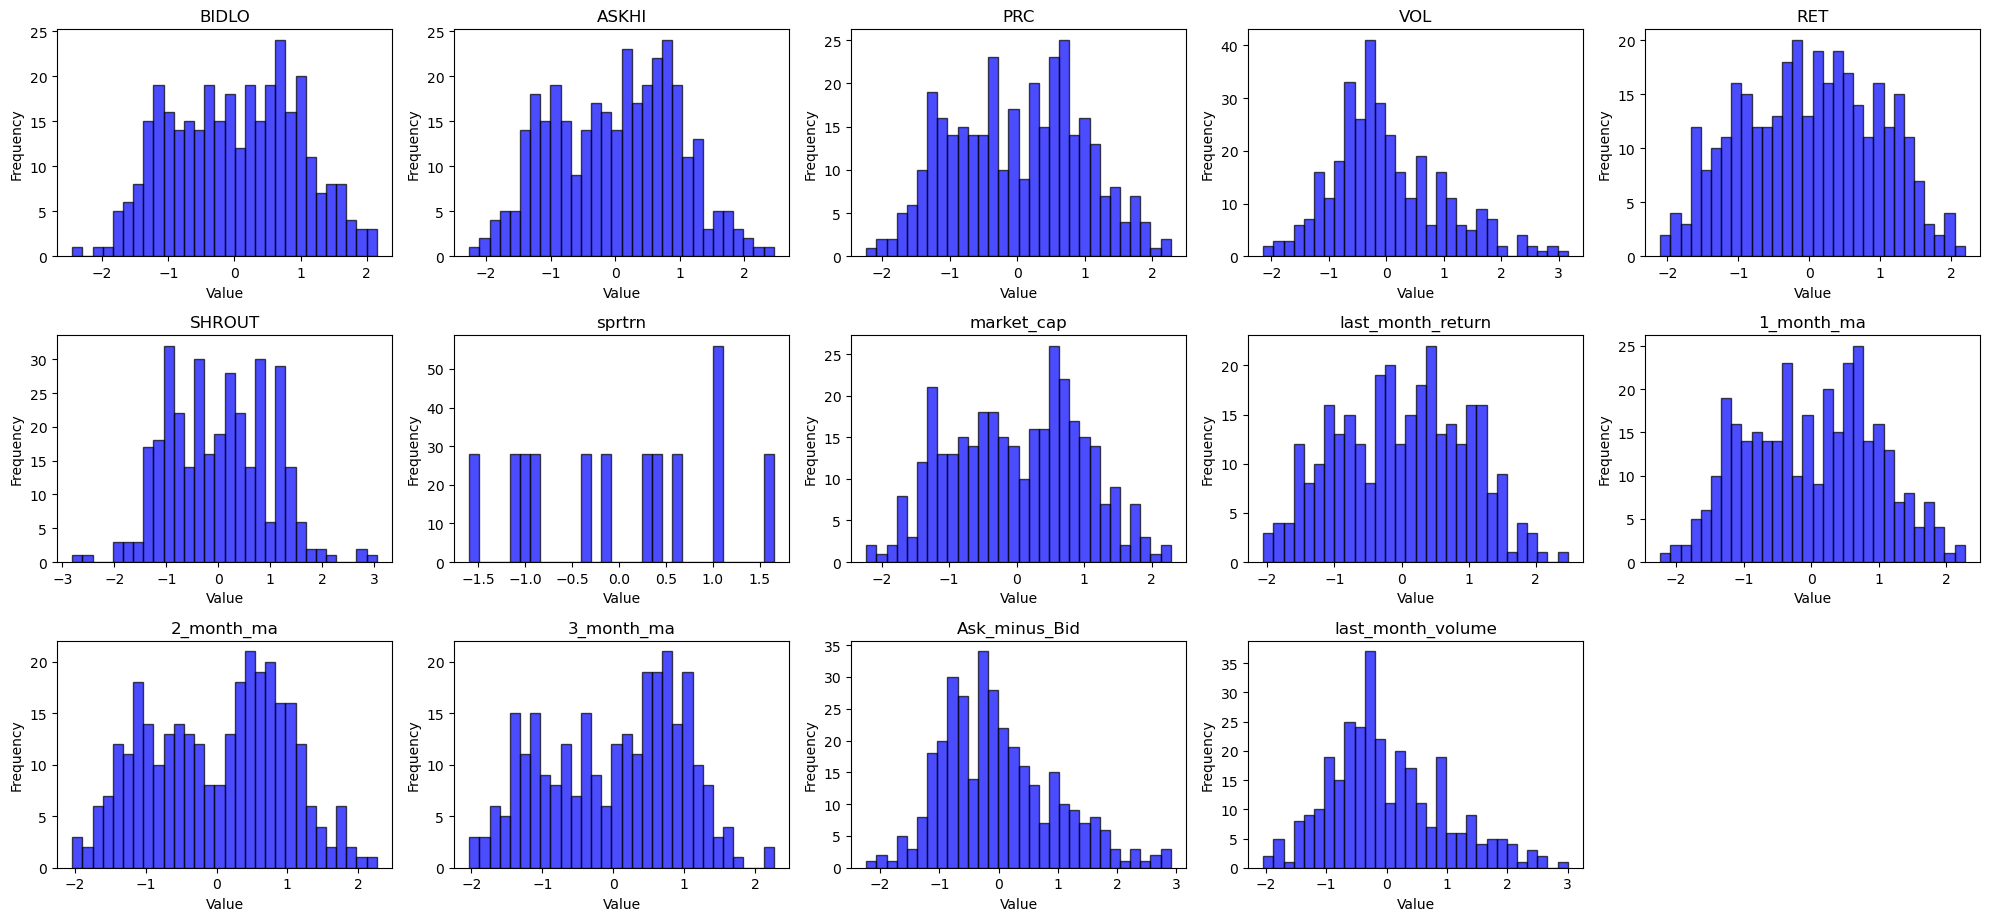

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate kurtosis and skewness for each numeric variable
numeric_columns = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'sprtrn', 'market_cap', 'last_month_return', 
                   '1_month_ma', '2_month_ma', '3_month_ma', 'Ask_minus_Bid', 'last_month_volume']
kurtosis_values = dowjones[numeric_columns].kurtosis()
skewness_values = dowjones[numeric_columns].skew()

# Print kurtosis and skewness values for each numeric variable
print("Kurtosis:")
print(kurtosis_values)
print("\nSkewness:")
print(skewness_values)

# Plot histograms for each numeric variable
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 5, i)
    plt.hist(dowjones[col], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
dowjones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 359
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             336 non-null    object        
 1   date               336 non-null    datetime64[ns]
 2   SICCD              336 non-null    float64       
 3   COMNAM             336 non-null    object        
 4   market_cap         336 non-null    float64       
 5   SHROUT             336 non-null    float64       
 6   VOL                336 non-null    float64       
 7   PRC                336 non-null    float64       
 8   ASKHI              336 non-null    float64       
 9   BIDLO              336 non-null    float64       
 10  total              336 non-null    float64       
 11  negative           336 non-null    float64       
 12  positive           336 non-null    float64       
 13  sprtrn             336 non-null    float64       
 14  RET       

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

# Convert specified columns to categorical
dowjones['SICCD'] = dowjones['SICCD'].astype('category')
dowjones['comp_size'] = dowjones['comp_size'].astype('category')
dowjones['proper?'] = dowjones['proper?'].astype('category')
dowjones['dummy_negative'] = dowjones['dummy_negative'].astype('category')
dowjones['dummy_positive'] = dowjones['dummy_positive'].astype('category')
dowjones['dummy_total'] = dowjones['dummy_total'].astype('category')

dowjones.to_csv('standardized_monthly_dowjones_regression.csv', index=False)
dowjones_clean = dowjones.dropna()

# Select features and target variable
features = dowjones_clean.drop(columns=['next_month_return', 'TICKER', 'COMNAM', 'date'])
target = dowjones_clean['next_month_return']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, selector(dtype_include="object"))
    ])

# Define LassoCV model
lasso_cv = LassoCV(cv=5, random_state=42)

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('lasso', lasso_cv)])

# Fit the model
pipeline.fit(X_train, y_train)

# Print the best alpha
print("Best alpha:", pipeline.named_steps['lasso'].alpha_)

# Print the R^2 score
print("R^2 score:", pipeline.score(X_test, y_test))

# Access the model coefficients
model_coefs = pipeline.named_steps['lasso'].coef_
print("Model coefficients:", model_coefs)

Best alpha: 0.001543359095718916
R^2 score: 0.20114455265926767
Model coefficients: [ 0.009208   -0.         -0.00514673 -0.00049545 -0.         -0.00036428
 -0.0195996   0.00461202 -0.         -0.00470073  0.01749303 -0.01956055
 -0.00676609 -0.00509991 -0.         -0.         -0.01100282  0.01172395
  0.          0.00325451 -0.00041283 -0.00268155 -0.        ]


In [15]:
dowjones = dowjones.dropna()

# Add a new column 'pred_lasso' to the dowjones dataframe with predictions
dowjones['pred_lasso'] = pipeline.predict(dowjones.drop(columns=['tomorrow_return', 'TICKER', 'COMNAM', 'date']))

# Display the first few rows of the dataframe to verify the new column
print(dowjones.head())

plt.hist(dowjones['pred_lasso'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Predicted Lasso Distribution')
plt.xlabel('Predicted Lasso Returns')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

KeyError: "['tomorrow_return'] not found in axis"

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=12)

# Create pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('random_forest', rf_model)])

# Define parameter grid
param_grid = {
    'random_forest__n_estimators': [50, 100],
    'random_forest__max_depth': [None, 10],
    'random_forest__min_samples_split': [2, 5],
    'random_forest__min_samples_leaf': [1, 2]
}

# Perform grid search with reduced parameters and folds
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Print the best R^2 score
print("Best R^2 score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print("Test set R^2 score of the best model:", test_score)
